In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd '/content/drive/MyDrive/FPT Mask /data_211/data_211/Test Code'

/content/drive/MyDrive/FPT Mask /data_211/data_211/Test Code


In [ ]:
# %%capture
# pip install -U albumentations

In [13]:
import random
import cv2
from matplotlib import pyplot as plt
import albumentations as A
import glob
import os
import string
import random
from PIL import Image
import numpy as np
import ntpath
from utils import yolo_convert_pascal_voc, find_and_remove_empty_file
%matplotlib inline

## Change Path Save

In [41]:
cwd = os.getcwd()

# please fill full path contain images, labels
source_path_image = cwd + "/data_211_big/images/train/"
source_path_anno = cwd + "/data_211_big/labels/train/"

# please fill full path contain generated images, labels
distance_file_img = cwd + "/test/augs_test/images/"
distance_file_anno = cwd + "/test/augs_test/labels/"

if not os.path.exists(distance_file_img):
    os.makedirs(distance_file_img)
if not os.path.exists(distance_file_anno):
    os.makedirs(distance_file_anno)

In [42]:
find_and_remove_empty_file(source_path_image)
find_and_remove_empty_file(source_path_anno)

## Using Albumentations

In [43]:
# List all technique you want to augment
height = 640
width = 640
transform_1 = A.Compose(
    [
        A.HorizontalFlip(always_apply=True),
    ],
    bbox_params=A.BboxParams(format='yolo',min_visibility=0.2),
)
transform_2 = A.Compose(
    [
        A.Rotate(limit=40, always_apply=True),
    ],
    bbox_params=A.BboxParams(format='yolo',min_visibility=0.2),
)
transform_3 = A.Compose(
    [
        A.RandomCrop(height = height, width = width,always_apply=True),
    ],
    bbox_params=A.BboxParams(format='yolo',min_visibility=0.2),
)
transform_4 = A.Compose(
    [
        A.ToGray(always_apply=True),
    ],
    bbox_params=A.BboxParams(format='yolo',min_visibility=0.2),
)

In [44]:
list_transform = {"HorizontalFlip": transform_1,
                  "Rotate": transform_2,
                  "RandomCrop": transform_3,
                  "ToGray": transform_4}

In [45]:
def return_list_bbox(path_image:str, folder_anno:str):
    # get annotation path from path images path
    path_txt = folder_anno + ntpath.basename(path_image).split(".")[0] +".txt"
    # read annotation file 
    f = open(path_txt,"r")
    data = f.read()
    f.close()
    # split line by line 
    list_bbox = data.split("\n")
    # remove empty element
    list_bbox = [i for i in list_bbox if i != ""]
    list_bbox = [i.split(" ") for i in list_bbox]
    # move the last item in a list to the front in python to fit albumentations format
    for i,_ in enumerate(list_bbox):
        tmp = list_bbox[i]
        tmp = [float(e) for e in tmp]
        tmp.append(tmp.pop(tmp.index(tmp[0])))
        tmp[len(tmp)-1]= int(tmp[len(tmp)-1])
        list_bbox[i] = tmp
    
    return list_bbox

In [46]:
# merge all bouding box
def bbox_to_txt(list_bbox):
    list_bbox = [list(i) for i in list_bbox]
    for i in range(len(list_bbox)):
        a = list_bbox[i]
        # move label to the beginning of list
        tmp_num = a[len(a) - 1]
        a[1:5] = a[0:4]
        a[0] = tmp_num
        a = [str(e) for e in a]
        list_bbox[i] = " ".join(a)
    
    return "\n".join(list_bbox)

In [47]:
def augment_image(transform,path_image,folder_anno):
    image = cv2.imread(path_image)
    w,h,_ = image.shape
    if min(w,h) >= max(height,width):
        transformed = transform(image=image, bboxes=return_list_bbox(path_image,folder_anno))
        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']
        return transformed_image, transformed_bboxes
    else:
        return [],[]

## Generate Images

In [48]:
path_image_list = glob.glob(source_path_image + "/*.jpg")
path_anno_list = glob.glob(source_path_anno+ "/*.txt")

img_name = [ntpath.basename(path).split(".")[0] for path in path_image_list]
anno_name = [ntpath.basename(path).split(".")[0] for path in path_anno_list]
# find image have not anno
for i in img_name:
    if i not in anno_name:
        img_name.remove(i)
path_image_list = [source_path_image + f"/{i}.jpg" for i in img_name]

In [49]:
prefix = random.randint(999999, 99999999)
for i in range(len(path_image_list)):
    path_test = path_image_list[i]
    for name_technique,transform in list_transform.items():
        image, bbox = augment_image(transform, path_test,source_path_anno)

        if len(path_test) == 0 or len(bbox) == 0:
            continue
        else:
            file_name = ntpath.basename(path_test).split(".")[0]
            file_name_augment = name_technique + "_" + str(prefix) + "_" + file_name

            # Save image augment
            cv2.imwrite(distance_file_img + file_name_augment+".jpg", image)

            #Save annotation file
            f = open(distance_file_anno + file_name_augment +".txt","w")
            f.write(bbox_to_txt(bbox))
            f.close()

## Visualize Image

In [50]:
list_path_anno_gen = glob.glob(distance_file_anno + "/*.txt")

In [51]:
random_file = random.randint(0, len(list_path_anno_gen)-1)
anno_file = list_path_anno_gen[random_file]
anno_id = ntpath.basename(anno_file).split(".")[0]

boxes = []
f = open(anno_file, 'r')
img_path = os.path.join(distance_file_img, f'{anno_id}.jpg')
img = cv2.imread(img_path)
img_height, img_width, _ = img.shape
del img
data = f.read()
f.close()
data_test = data.split("\n")
data_test = [i for i in data_test if i != ""]
data_test = [i.split(" ") for i in data_test]
for i,_ in enumerate(data_test):
    tmp = data_test[i]
    tmp = [float(e) for e in tmp]
    box_descrip = tmp[1:]
    boxes.append(yolo_convert_pascal_voc(box_yolo= box_descrip, h= img_height, w= img_width,label= tmp[0]))

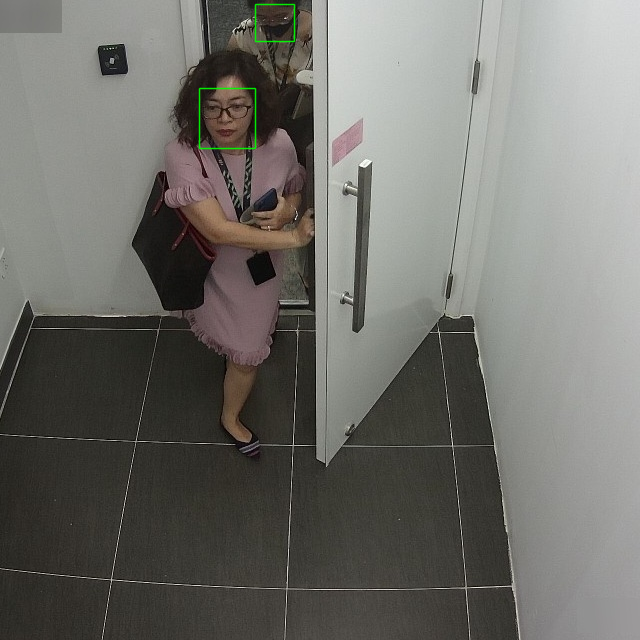

In [52]:
image = cv2.imread(img_path)

for anno_ in boxes:
    start_point = (anno_[1], anno_[2])
    end_point = (anno_[3], anno_[4])
    cv2.rectangle(image, start_point, end_point, (0, 255, 0), 1, cv2.LINE_AA)

new_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
new_image = Image.fromarray(new_image.astype(np.uint8))
new_image